# Exercise 8
## Fundamentals of Machine Learning, WiSe 20/21
### Authors: Catherine Knobloch, Elias Olofsson, Julia Siegl
    Version information:
        2021-02-19: v.1.0. First public release. 

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('image', cmap='gray')

from sklearn.datasets import load_digits
from sklearn import decomposition

# Produce inline vector graphics
%config InlineBackend.figure_format = 'svg'

## 2. Non-negative matrix factorization

In [2]:
# Importing the digits dataset
digits = load_digits()
X = digits["data"]/255.
Y = digits["target"]
print(X.shape, Y.shape)

(1797, 64) (1797,)


## 2.1 Comparison of scikit-learn's NMF with SVD (6 pts)

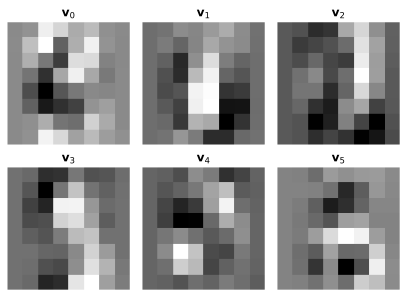

In [3]:
# Center the data for SVD
x_mean = X.mean(axis=0)
X_cent = X - x_mean

# Perform SVD
u, s, vh = np.linalg.svd(X_cent)

# Since numpy's SVD implementation sorts the singular values in descending order,
# we can simply index the first 6 columns of matrix vh, to acess the corresponding 
# basis vectors. Plotting these as images:
fsize = (5.6,4)
fig, ax = plt.subplots(2,3,figsize=fsize, constrained_layout=True, sharex=True,sharey=True)
ax = ax.flatten()
for i in range(6):
    ax[i].imshow((vh[i]+x_mean).reshape(8,8))
    ax[i].axis('off')
    ax[i].set_title(f'$\mathbf{{v}}_{{{i}}}$')
plt.show()

(1797, 10) (10, 64) (1797, 64)


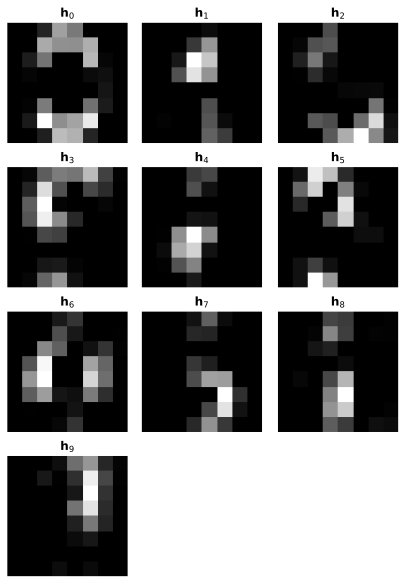

In [4]:
# Use sklearn's NMF implementation on X.
model = decomposition.NMF(n_components=10, init='random', random_state=0)
Z = model.fit_transform(X)
H = model.components_
print(Z.shape, H.shape, X.shape)

# Plot the basis vectors of H.
fsize = (5.6,8)
fig, ax = plt.subplots(4,3,figsize=fsize, constrained_layout=True, sharex=True,sharey=True)
ax = ax.flatten()
for i in range(10):
    ax[i].imshow(H[i].reshape(8,8))
    ax[i].axis('off')
    ax[i].set_title(f'$\mathbf{{h}}_{{{i}}}$')
fig.delaxes(ax[10])
fig.delaxes(ax[11])
plt.show()

When comparing the basis vectors generated by SVD and NMF, one can note they in general yield quite similar results and vaguely resembles each other visually, at least in character. In some cases whole digits can be discerned, but in others, only distinct parts of individual digits can be clearly identified. 

However, the NMF basis vectors manages to isolate characteristics of the digits dataset to a larger extent than SVD. Prominent local shapes and patterns are captured and presented on a neutral backdrop (i.e. zeros). 
On the other hand, SVD presents seemingly blended images which captures 'global' charcteristics, and thus the basis vectors more closly resembles actual digits. The basis vectors of NMF can instead be interpreted as 'pieces' or smaller chunks, which together can be arranged to form digits.     

## 2.2 Implementation (6 pts)

In [5]:
def non_negative(data, num_components, iterations=1000): 
    # Random initialization of Z and H. 
    Z = np.abs(np.random.normal(size=(data.shape[0], num_components)))
    H = np.abs(np.random.normal(size=(num_components, data.shape[1])))
    
    # Iteratively solve for Z and H
    res = []
    for t in range(iterations):
        # Update Z and H.
        H *= (Z.T @ data)/np.clip(Z.T @ Z @ H, a_min=1e-8, a_max=None)
        Z *= (data @ H.T)/np.clip(Z @ H @ H.T, a_min=1e-8, a_max=None)
        
        # Save residual
        res.append(0.5*np.linalg.norm(data-Z@H)**2)
    
    return Z, H, np.array(res)

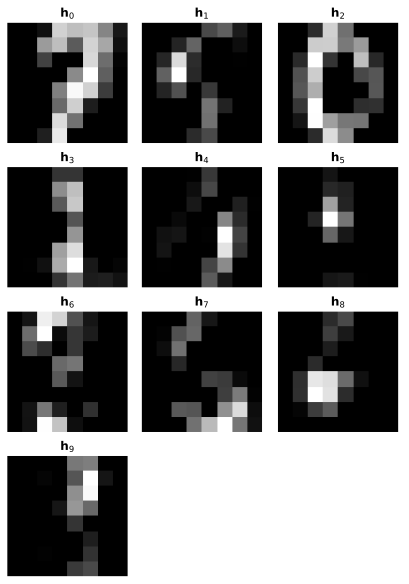

In [6]:
# Perform NMF of X using our own implementation.
Z, H, res = non_negative(X, num_components=10)

# Plot the basis vectors of H.
fsize = (5.6,8)
fig, ax = plt.subplots(4,3,figsize=fsize, constrained_layout=True, sharex=True,sharey=True)
ax = ax.flatten()
for i in range(10):
    ax[i].imshow(H[i].reshape(8,8))
    ax[i].axis('off')
    ax[i].set_title(f'$\mathbf{{h}}_{{{i}}}$')
fig.delaxes(ax[10])
fig.delaxes(ax[11])
plt.show()

We get seemingly very similar results to sklearn's NMF implementation. However, due to the random initialization and the fact that the factorization is not unique, we may get different results from run to run. However, approximately the same set of basis vectors are reached every time, given enough time for the algorithm to converge. They may however come in a different order, and differ slightly in their values.

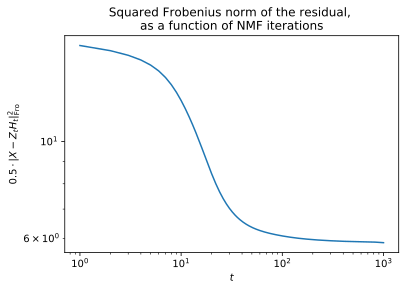

In [7]:
# Plot the evolution of the residual during the NMF in a loglog plot.
plt.loglog(1+np.arange(len(res)), res)
plt.xlabel('$t$')
plt.ylabel('$ 0.5 \cdot \|X-Z_t H_t\|_{\mathrm{Fro }}^{2}$')
plt.title('Squared Frobenius norm of the residual, \nas a function of NMF iterations')
plt.show()

As can be seen in the plot, the residual quickly converges while also showcasing a non-increasing behaviour.

# 3. Recommmender system (12 pts)

In [8]:
# Column headers for the dataset
users_cols = ['user id','age','gender','occupation','zip code']
movies_cols  = ['movie id','movie title','release date',
'video release date','IMDb URL','unknown','Action',
'Adventure','Animation','Childrens','Comedy','Crime',
'Documentary','Drama','Fantasy','Film-Noir','Horror',
'Musical','Mystery','Romance','Sci-Fi','Thriller',
'War','Western']
ratings_cols = ['user id','movie id','rating','timestamp']

# Import the datasets
users = pd.read_csv('ml-100k/u.user', sep='|', 
                    names=users_cols, encoding= 'latin-1')
movies = pd.read_csv('ml-100k/u.item', sep= '|', 
                     names=movies_cols, encoding='latin-1')
ratings = pd.read_csv('ml-100k/u.data', sep= '\t', 
                      names=ratings_cols, encoding='latin-1')

In [9]:
# Peek at the dataframes
users.head()

,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [10]:
movies.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [11]:
ratings.head()

,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [12]:
def recommend_movies(reconstruction, user_id, movies, ratings, N):
    '''
    Get the best N movie suggestions for a chosen user.
    
    Parameters:
    -----------
    reconstruction: pandas.Dataframe
        NMF reconstruction of the original ratings matrix.
    user_id: int
        Unique identifier of the (single) chosen user.
    movies: pandas.Dataframe
        Dataframe containing all information on the movies in the database.
    ratings: pandas.Dataframe
        Dataframe containing the ratings of all users.
    N: int
        Number of movies to suggest.
    
    Returns:
    --------
    movie_suggestions: pandas.Series
        The top N suggestions for unwatched movies for the selected user, 
        with the corresponding predicted rating scores.
    '''
    # Extract the movies the current user has already seen (i.e. rated).
    movies_already_rated = ratings.loc[ratings['user id']==user_id, 'movie id'].values
    
    # Filter out previously seen movies from the reconstruction.
    movies_not_seen      = reconstruction.loc[user_id].drop(movies_already_rated)
    
    # Sort to obtain the N best suggestions for new movies.
    movie_suggestions    = movies_not_seen.sort_values(ascending=False)[:N]
    
    return movie_suggestions

Create a supplimentary function to compare user ratings with suggestions given by the algorithm. 

In [13]:
# Set sequential colormap for the bar graphs.
cmap = 'viridis'
colors = getattr(plt.cm, cmap)(np.linspace(0,1,5))

def suggest_and_compare(reconstruction, user_id, movies, ratings, N):
    '''
    Get N movie suggestions for a given (single) user. Plot the genre distribution
    of the user's original ratings, and the distribution of the suggested movies.
    '''
    #---------------------------------------------------------------------------------
    # Get all movies rated by the current user, sort by movie id.
    df_user_rat = ratings[ratings['user id']==user_id].sort_values(by='movie id')
    
    # Extract the movie id:s and create a 'genre matrix' of the rated movies.    
    movies_rated = df_user_rat['movie id'].values
    df_genre_mat = movies[movies['movie id'].isin(movies_rated)].iloc[:,5:]
    
    # Add the ratings to the genre matrix
    df_genre_mat['rating'] = df_user_rat['rating'].values
    
    # Group by rating, and sum no. of movies per genre, per rating outcome. 
    df_genre_mat = df_genre_mat.groupby('rating').sum().T
    
    # Fix colors to specific rating outcomes (i.e. 5 = yellow, etc.) 
    col_idx = df_genre_mat.columns.values-1
    
    # Plot stacked bar graph for the original ratings.
    df_genre_mat.plot.bar(stacked=True, color=colors[col_idx], legend='reverse')
    plt.ylabel('No. of ratings')
    plt.title(f'All ratings given by user: {user_id}')
    plt.show()
    #---------------------------------------------------------------------------------
    # Get movie suggestions for the current user.
    suggestions = recommend_movies(reconstruction, user_id, movies, ratings, N)
    
    # Create a 'genre matrix' of the suggested movies.
    df_genre_mat = movies.loc[suggestions.index].iloc[:,5:]
    
    # Add the predicted ratings, round it up to nearest int.
    df_genre_mat['rating'] = np.ceil(np.clip(suggestions.values, 0, 5)).astype('int')
    
    # Group by rating, and sum no. of movies per genre, per rating outcome. 
    df_genre_mat = df_genre_mat.groupby('rating').sum().T
    
    # Fix colors to specific rating outcomes (i.e. 5 = yellow, etc.) 
    col_idx = df_genre_mat.columns.values-1
    
    # Plot stacked bar graph for the suggestions.
    df_genre_mat.plot.bar(stacked=True, color=colors[col_idx], legend='reverse')
    plt.ylabel('No. of suggestions')
    plt.title(f'Top {N} suggestions for user: {user_id}')
    plt.show()

Create a joint ratings dataframe for the matrix, using different methods for filling NaN-positions.

In [14]:
# Dataframe with NaN positions untouched.
rat_df_NaN = ratings.pivot(index='user id', columns='movie id', values='rating')

# Fill NaN:s with zeros.
fill_value = 0
rat_df = rat_df_NaN.fillna(fill_value)

# Fill NaN:s with total mean movie rating.
tot_mean_rating = rat_df_NaN.mean().mean()
rat_df_totmean  = rat_df_NaN.fillna(tot_mean_rating)

# Fill NaN:s with mean rating of each individual movie.
mean_rating = rat_df_NaN.mean()
rat_df_mean = rat_df_NaN.fillna(mean_rating)

Perform NMF on the chosen ratings matrix and use the resulting matrices Z and H to reconstruct the ratings matrix.

In [15]:
# Choose method to replace NaN.
#X = rat_df.to_numpy()             # zeros 
X = rat_df_totmean.to_numpy()      # tot mean 
#X = rat_df_mean.to_numpy()        # individual movie mean

# NMF on the ratings matrix.
model = decomposition.NMF(n_components=20, init='random', random_state=0)
Z = model.fit_transform(X)
H = model.components_

# Reconstruct results from NMF into a new dataframe
reconstruction = pd.DataFrame(Z @ H, columns = rat_df.columns, index=rat_df.index)

Use the reconstruction to give suggestions for chosen users. Plot and compare.

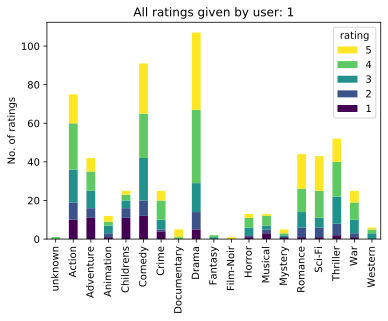

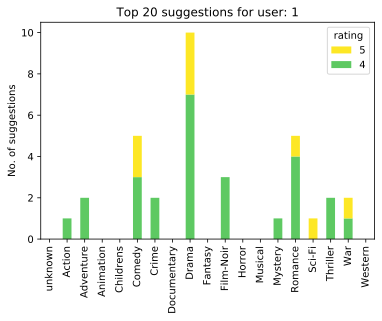

In [16]:
user_id = 1
suggest_and_compare(reconstruction, user_id, movies, ratings, N=20)

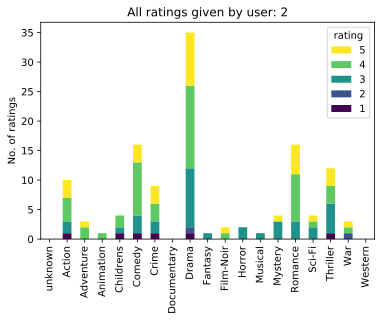

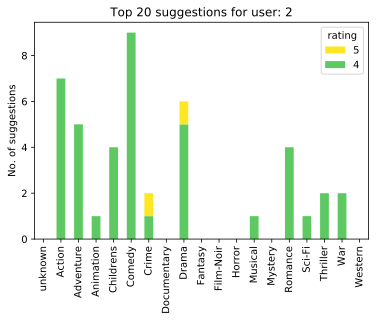

In [17]:
user_id = 2
suggest_and_compare(reconstruction, user_id, movies, ratings, N=20)

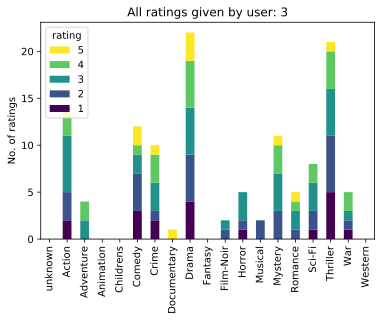

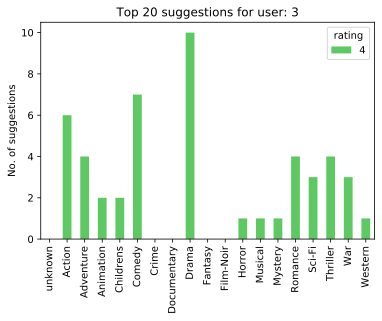

In [18]:
user_id = 3
suggest_and_compare(reconstruction, user_id, movies, ratings, N=20)

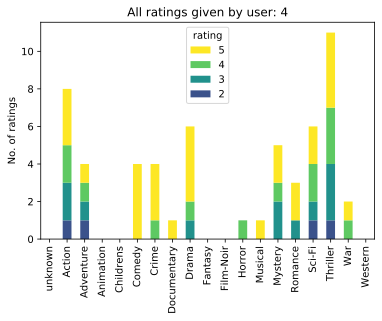

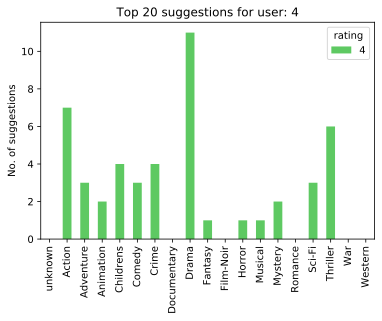

In [19]:
user_id = 4
suggest_and_compare(reconstruction, user_id, movies, ratings, N=20)

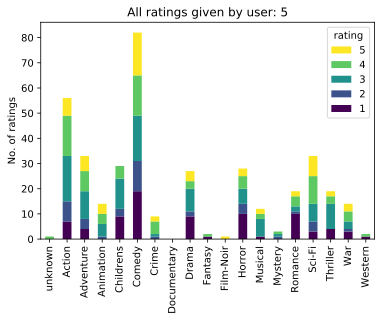

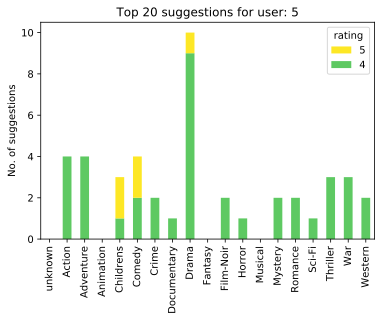

In [20]:
user_id = 5
suggest_and_compare(reconstruction, user_id, movies, ratings, N=20)

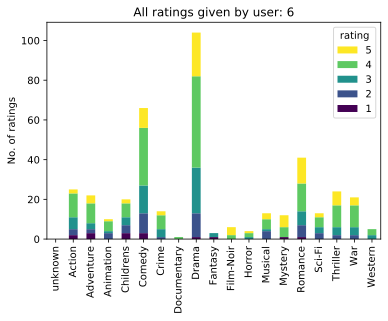

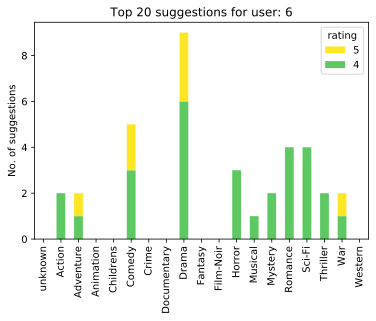

In [21]:
user_id = 6
suggest_and_compare(reconstruction, user_id, movies, ratings, N=20)

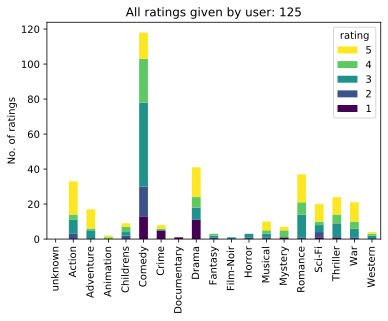

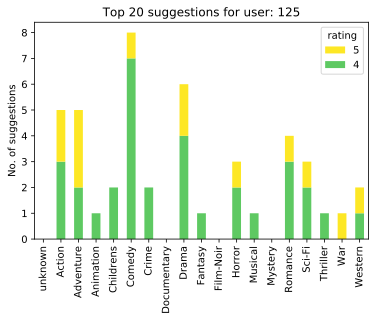

In [22]:
user_id = 125
suggest_and_compare(reconstruction, user_id, movies, ratings, N=20)

Most recommendations seems to make sense, and are seemingly reflecting the user's old ratings. However, not all suggestions are done correctly, at least seemingly by looking at the genre/ratings distribution.

Case in point could for example be the suggestions given to user no. 5 and 6, which from the ratings data looks to be a huge fans of comedy and thriller movies, respectivley. Problem is that these people are mostly being recommended drama movies, or from other categories they are not very interested in. This clearly showcases how the recommendations are not only based on the single user's preferences, but also on the global set of ratings given by all users. And since the drama category is heavily represented in the dataset, a user that is completely uninterested by dramas, tends to still get recommended dramas. 

There are however cases where people who does not follow the most popular trends, still get somewhat correct and personalized recommendations. User no. 125, seen above, is also a fan of comedy but contrastingly gets genre recommendations approximately proportional to their ratings distribution. I'm not sure if this is due to luck with the NMF, or something else. Perhaps it could be that the algorithm captures 'local groupings' of users in the matrix X, i.e. users in rows close to each other, which affects each other to a larger extent than users 'far apart' in the dataset. I do not know if this is actually the case or not, but I could imagine it being the case.  

To try and identify rows in matrix H which can be interpreted as prototypical user preferences, we take the matrix H and multiply it with the 'genre matrix' of all movies. We normalize the response per genre for better comparison, since otherwise only the most popular genres are visible (drama, comedy etc.) and use imshow for visualization.

In [23]:
# Shape of H
print(H.shape) # (no. of NMF components, No. of movies in database)

# 'Genre matrix'
df_movies_genres = movies.iloc[:,5:]
df_movies_genres.head()

(20, 1682)


,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


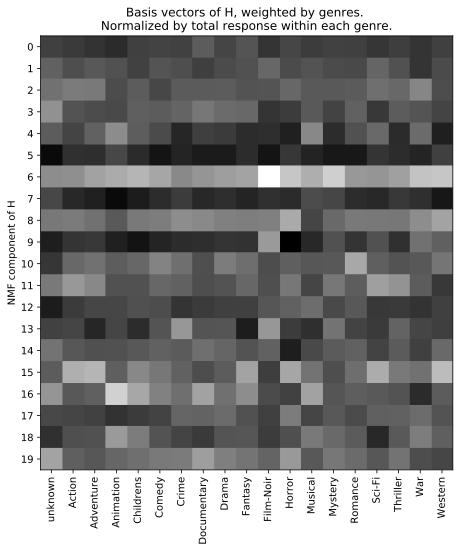

In [24]:
# Multiply together and plot.
component_category = H @ df_movies_genres.values
plt.figure(figsize=(8,8))
plt.imshow(component_category/component_category.sum(axis=0))
plt.xticks(np.arange(len(movies_cols[5:])), movies_cols[5:], rotation='vertical')
plt.yticks(np.arange(component_category.shape[0]),np.arange(component_category.shape[0]))
plt.ylabel('NMF component of H')
plt.title('Basis vectors of H, weighted by genres. \nNormalized by total response within each genre.')
plt.show()

By studying the columns in the picture above, one can get a feeling for the relative importance of a certain row in H for a specific category. E.g. row no. 6 gives the prototypical behaviour of someone who likes Film-Noir. But at the same time, it is very difficult to draw conlusions from this alone, since it showcases how intertwined the interests of the users are.